# Aspect Identifying via Clustering for Classification

In [1]:
import preprocessor as p #https://pypi.org/project/tweet-preprocessor/
import numpy as np
import pandas as pd
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## A. Preprocessing and Cleaning the Data

In [2]:
df = pd.read_csv('data/Tweets.csv')
tweets = df.text

#### To start, we are going to review the initial set of negative reasons, the original aspect classification, as we move along towards defining our own clusters

In [3]:
df.negativereason.value_counts(dropna=False)

NaN                            5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

#### The below value shows that 45% of the dataset is listed as NaN or Can't Tell for the aspect or reason behind the tweet

In [4]:
(5462+1190)/14640

0.45437158469945355

#### Turn tweet to lowercase, remove all html or links, then clean up hashtags, mentions, and emojis

In [5]:
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = BeautifulSoup(tweet, 'html.parser').getText()
    tweet = p.clean(tweet)
    return tweet

In [6]:
clean_tweets = []
for tweet in tweets:
    clean_tweets.append(preprocess(tweet))

In [7]:
tweets = clean_tweets

## B. Tokenizing and Vectorizing the Terms in the Tweets for Clustering

#### Define stopwords and stemmer (how the words are trimmed and small ones removed)

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [9]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        #remove words that are 2 characters or less
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [10]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        #remove words that are 2 characters or less
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens

#### Compare the list of stemmed vs tokenized to create the vocabulary we will use for the clustering

In [11]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweets:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'tweets', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

#### Only use words that appear 20% of the time, because most of language is repetitive 
<em>(https://www.strategiesinlanguagelearning.com/repetition-in-language-learning/)</em>

In [13]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.20,
                                   stop_words='english', max_features=1000,
                                   strip_accents='unicode', use_idf=True, 
                                   preprocessor=preprocess,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets) #fit the vectorizer to tweets

C:\Code\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "con" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'v

Wall time: 12.8 s


In [14]:
terms = tfidf_vectorizer.get_feature_names()
#print(terms)
tfidf_vectorizer.fit(tweets)
%time text = tfidf_vectorizer.transform(tweets)
#print(text)

C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 17.8 s


## C. Clustering the terms

### First pass, using inertia score and elbow curve to find optimal cluster amount

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


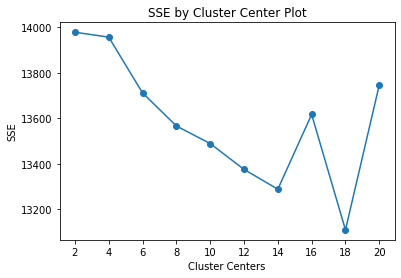

In [15]:
def find_optimal_amt_of_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_amt_of_clusters(text, 20)

In [16]:
cluster_amt = 8

In [17]:
num_clusters = cluster_amt

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 8.68 s


In [18]:
Tweets = {'tweet': tweets, 'cluster': clusters}

frame = pd.DataFrame(Tweets)
frame['Aspect'] = "Miscellaneous"

frame['cluster'].value_counts() #number of tweets per cluster (clusters from 0 to 9)


4    8850
2    1493
3     976
6     846
0     842
5     620
1     605
7     408
Name: cluster, dtype: int64

In [19]:
aspectsDF = pd.DataFrame(columns = ['Word', "Reason"])

### Now with the terms in clusters, we are going to manually review and assign them for classification

In [20]:
print("Top terms per cluster:")

#https://7esl.com/contractions-list/
#first pass throughs of model gave way to words that were most common but do not contribute to aspects, so they were added here to custom stop_words
contractions_and_common_words = [
    "n't","'s","'m","'ll","'d","'ve","'re","flying","flight","flightled","airline","fleek","fleet","did","does","flt"]
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(cluster_amt):
    print("Cluster %d words:" % i, end='')
    name = "Cluster %d words:" % i
    
    for ind in order_centroids[i, :20]:
        word = ' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        word = word.replace(" ", "")
        if word not in aspectsDF.values and word not in contractions_and_common_words:
            print(word, end=',')
            aspectsDF.loc[len(aspectsDF.index)] = [word, "Miscellaneous"]
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:
Cluster 0 words:cancelled,rebook,hold,tomorrow,help,hour,today,dfw,need,

Cluster 1 words:service,customer,worst,thanks,terrible,phone,poor,great,line,agent,

Cluster 2 words:why,bag,time,change,working,know,because,booking,waited,online,

Cluster 3 words:just,late,flightr,got,days,want,trying,delayed,sent,

Cluster 4 words:please,gate,seats,guys,like,check,making,love,

Cluster 5 words:plane,sit,boarding,left,new,passengers,issue,leaving,

Cluster 6 words:minutes,

Cluster 7 words:awesome,appreciate,follow,good,updates,very,safe,okay,yes,respond,



# D. Assigning the Aspects
<p> With the clustering analysis put together, we see words that correspond and have correlation together. Instead of assigning a cluster per tweet, we use the most commonly found and correlated words to create a dictionary of terms. This dictionary will then be used to assign Aspects to the tweets based on the words found. Because we saw similar words in certain clusters, we merged into the aspects listed below.</p>

In [21]:
aspect_assignments = {'Customer Service':['accomodate', 'contact', 'emailed', 'fix', 'staff', 'speak', 'talk', 
                                          'care', 'experience', 'rep', 'issue', 'thanks', 'hold', 'thank', 'appreciate', 
                                          'response', 'service', 'customer', 'phone', 'agent', 'email', 'speak', 'help', 
                                          'please', 'call', 'refund', 'need'],
                      'Ongoing Flight(s)':['travel', 'wifi', 'leaving', 'updates', 'weather', 'attendant', 'connecting', 
                                           'early', 'arrived', 'landed', 'gate', 'delay', 'delayed', 'late', 'status', 
                                           'schedule', 'cancelled', 'cancel', 'pilots', 'pilot', 'passengers', 'passenger', 
                                           'boarding'],
                      'Booking': ['sit', 'pass', 'credit', 'miles', 'hotel', 'app', 'fee', 'voucher', 'upgrade', 'class',
                                  'available', 'website', 'online', 'book', 'booking', 'seats', 'seat', 'boarding', 
                                  'rebook', 'confirmation', 'reschedule', 'ticket', 'reserved'],
                      'Luggage': ['bag', 'check', 'lost', 'baggage', 'bags', 'luggage', 'claim'],
                      'Wait Times': ['wait', 'waited', 'stuck', 'line', 'hour', 'hours', 'minutes', 'days', 'today', 
                                     'tomorrow', 'time', 'min', 'hrs']
                      }

def get_key(val):
    for key, value in aspect_assignments.items():
        for item in value:
            if (val == item):
                return key

In [22]:
def get_aspect_for_tweet(tweet):
    cs = 0
    of = 0
    bo = 0
    lu = 0
    wt = 0
    me = 0
    tweet_array = tweet.split(" ")
    for word in tweet_array:
        tof = False
        for value in aspect_assignments.values():
            if (word in value):
                tof = True
                aspect = get_key(word)
                if aspect == 'Customer Service':
                    cs += 1
                if aspect == 'Ongoing Flight(s)':
                    of += 1
                if aspect == 'Booking':
                    bo += 1
                if aspect == 'Luggage':
                    lu += 1
                if aspect == 'Wait Times':
                    wt += 1
                break

    assignments = {'cs': cs,'of': of,'bo': bo,'lu': lu,'me': me}
    test_value = max(assignments.values())
    test_key = 'me'
    if test_value > 0:
        for key, value in assignments.items():
            if test_value == value:
                test_key = key
                break
    aspects = {'cs': 'Customer Service', 'of': 'Ongoing Flight(s)', 'bo': 'Booking', 'lu': 'Luggage', 'me': "Miscellaneous"} 
    tweet_index = frame.index[frame['tweet'] == tweet].tolist()[0]
    frame.loc[tweet_index, 'Aspect'] = aspects[test_key]

In [23]:
for tweet in tweets:
    get_aspect_for_tweet(tweet)

## E. Comparison of Values to see if the clustering has defined more aspects

In [24]:
df['Aspect'] = frame['Aspect']

In [25]:
df.negativereason.value_counts(dropna=False)

NaN                            5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

#### Here is the original rate of missing data (45%)

In [26]:
(5462+1190)/14640

0.45437158469945355

In [27]:
df.Aspect.value_counts(dropna=False)

Miscellaneous        6027
Customer Service     4710
Ongoing Flight(s)    2251
Booking              1013
Luggage               639
Name: Aspect, dtype: int64

#### Here is our new rate of missing classified data (41%) showing that the aspect clustering improves the dataset to a small degree, but the manual labor involved may not provide as much benefit as intended.

In [28]:
6027/14640

0.41168032786885245